# Data Cleaning

Exclusion critera:
1. Don't use social media
2. Was aware of one of the rumours
2. An outlier in completion time (>3 std devs below the mean)

### 1. Drop participants who were aware of either rumour

In [1]:
import pandas as pd
import numpy as np

In [2]:
participants = pd.read_json("../data/raw/mock_data/participant-schema.json",orient="records")
num_participants = len(participants["PROLIFIC_ID"].unique())
dummies = ["gender","affiliatedMovements","socialMedias"]
for col in dummies:
    participants = participants.explode(col)
participants = pd.get_dummies(participants,columns=dummies).max(level=0)
assert len(participants) == num_participants, "Number of participants changed"
num_participants = len(participants["PROLIFIC_ID"].unique())
print(f"Original number of participants: {num_participants}")

Original number of participants: 499


In [3]:
post_study = pd.read_json("../data/raw/mock_data/post-study-schema.json",orient="records")
assert len(post_study) == len(participants), "Dataframes have different row lengths"
not_aware = post_study[~(post_study["awareR1"].astype(bool) | post_study["awareR2"].astype(bool))]["PROLIFIC_ID"]
num_not_aware = len(not_aware.unique())
print(f"{num_participants-num_not_aware} aware of a rumour, {num_not_aware} remaining participants.")

58 aware of a rumour, 441 remaining participants.


Drop those participants

In [4]:
participants = participants[participants["PROLIFIC_ID"].isin(not_aware)]
num_participants = len(participants["PROLIFIC_ID"].unique())
assert len(participants) == num_not_aware, "Dropped extras?"

### 2. Drop participants who were outliers in the amount of time taken

Outlier: participants who the amount of time taken is more than 3 standard deviations below the mean 
- not above as we put a time cap on the time taken

In [5]:
posts = pd.read_json("../data/raw/mock_data/posts-schema.json",orient="records")
posts = posts[posts["PROLIFIC_ID"].isin(not_aware)]
assert len(posts) == num_not_aware, "Dropped extras?"
posts = posts.explode("posts")
posts = pd.concat([posts.drop(['posts'], axis=1), posts['posts'].apply(pd.Series)], axis=1)
assert (posts.groupby("PROLIFIC_ID").count()["id"] == 20).all(), "Some people have a different number of posts"
posts

,id,PROLIFIC_ID,STUDY_ID,SESSION_ID,treatment,secondsTaken,rumour,rumourId,evidence,code,mockGender,timestamp,warning,reshared
0,1,1,1,1,True,93.87,R1,R1-1,high,questions,Female,57,False,True
0,1,1,1,1,True,93.87,R2,R2-1,low,questions,Female,9,False,True
0,1,1,1,1,True,93.87,R1,R1-2,high,affirms,Male,48,False,True
0,1,1,1,1,True,93.87,R2,R2-2,low,affirms,Female,21,True,False
0,1,1,1,1,True,93.87,R1,R1-3,high,affirms,Male,23,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,499,499,1,499,False,93.32,R2,R2-8,low,neutral,Male,43,False,True
498,499,499,1,499,False,93.32,R1,R1-9,high,questions,Male,1,False,True
498,499,499,1,499,False,93.32,R2,R2-9,low,affirms,Female,2,False,False
498,499,499,1,499,False,93.32,R1,R1-10,high,denies,Male,40,False,True


1 outlier(s) in completion time, 440 remaining participants.


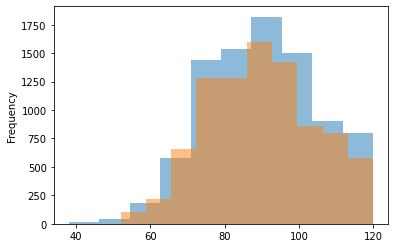

In [6]:
from scipy.stats import zscore
posts.secondsTaken.plot.hist(alpha=0.5)
z_scores = zscore(posts["secondsTaken"])
not_outliers = posts[z_scores > -3]
not_outliers.secondsTaken.plot.hist(alpha=0.5)
num_not_outliers = len(not_outliers["PROLIFIC_ID"].unique())
not_outliers = not_outliers["PROLIFIC_ID"]
print(f"{num_participants-num_not_outliers} outlier(s) in completion time, {num_not_outliers} remaining participants.")

In [7]:
participants = participants[participants["PROLIFIC_ID"].isin(not_outliers)]
posts = posts[posts["PROLIFIC_ID"].isin(not_outliers)]
num_participants = len(participants["PROLIFIC_ID"].unique())
assert num_participants == num_not_outliers, "Dropped extras?"
assert num_participants == len(posts.groupby("PROLIFIC_ID").count()), "participant counts don't match in between participants and posts df"

Write to file

In [8]:
participants.to_csv("../data/processed/mock_data/participant-schema.csv",index=False)
posts.to_csv("../data/processed/mock_data/posts-schema.csv",index=False)
post_study.to_csv("../data/processed/mock_data/post-study-schema.csv",index=False)